## Import libraries

In [18]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy.sql import select
from sqlalchemy.orm import relationship
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Table, Column, Integer, String, Enum, TIMESTAMP, TEXT, ForeignKey, text, DATE, create_engine, ForeignKeyConstraint, UniqueConstraint, create_engine

## Define base

In [19]:
Base = declarative_base()

## Table definition

In [20]:
class Project(Base):
  '''
  Table schema for Project
  '''
  __tablename__ = 'project'
  __table_args__ = ( UniqueConstraint('igf_id'),)

  project_id   = Column('project_id', Integer, primary_key=True, nullable=False)
  igf_id       = Column('igf_id', String(20), nullable=False)
  project_name = Column('project_name', String(100))
  start_date   = Column('start_date', DATE(), nullable=True)
  description  = Column('description', TEXT())
  requirement  = Column('requirement', Enum('FASTQ', 'ALIGNMENT', 'ANALYSIS'), server_default='FASTQ')
  projectuser  = relationship('ProjectUser', backref="project")
    
  def __repr__(self):
    return "Project(project_id = '{self.project_id}', " \
                    "igf_id = '{self.igf_id}'," \
                    "project_name = '{self.project_name}'," \
                    "start_date = '{self.start_date}'," \
                    "description = '{self.description}'," \
                    "requirement = '{self.requirement}')".format(self=self)
class User(Base):
  '''
  Table schema for User
  '''
  __tablename__ = 'user'
  __table_args__ = (
    UniqueConstraint('user_igf_id'),
    UniqueConstraint('email_id'))

  user_id       = Column('user_id', Integer, primary_key=True, nullable=False) 
  user_igf_id   = Column('user_igf_id', String(10))
  name          = Column('name', String(25), nullable=False)
  hpc_user_name = Column('hpc_user_name', String(8))
  category      = Column('category', Enum('HPC_USER','NON_HPC_USER','EXTERNAL'), nullable=False, server_default='NON_HPC_USER')
  status        = Column('status', Enum('ACTIVE', 'BLOCKED', 'WITHDRAWN'), nullable=False, server_default='ACTIVE')
  email_id      = Column('email_id', String(20), nullable=False)
  date_stamp    = Column('date_stamp', TIMESTAMP(), nullable=True)
  password      = Column('password', String(129))
  projectuser   = relationship('ProjectUser', backref="user")
  
  def __repr__(self):
    return "User(user_id = '{self.user_id}'," \
                 "user_igf_id = '{self.user_igf_id}'," \
                 "name = '{self.name}', " \
                 "hpc_user_name = '{self.hpc_user_name}',"\
                 "category = '{self.category}'," \
                 "status = '{self.status}'," \
                 "email_id = '{self.email_id}'," \
                 "date_stamp = '{self.date_stamp}'," \
                 "password = '{self.password}')".format(self=self)

class ProjectUser(Base):
  '''
  Table schema for ProjectUser
  '''
  __tablename__ = 'project_user'
  __table_args__ = (
    UniqueConstraint('project_id','data_authority'),)
    
  project_user_id = Column('project_user_id', Integer, primary_key=True, nullable=False)
  project_id      = Column('project_id', Integer, ForeignKey("project.project_id", onupdate="CASCADE", ondelete="CASCADE"), nullable=False)
  user_id         = Column('user_id', Integer, ForeignKey("user.user_id", onupdate="CASCADE", ondelete="CASCADE"), nullable=False)
  data_authority  = Column('data_authority', Enum('T'))

  def __repr__(self):
    return "ProjectUser(project_user_id = '{self.project_user_id}'," \
                        "project_id = '{self.project_id}'," \
                        "user_id = '{self.user_id}'," \
                        "data_authority = '{self.data_authority}')".format(self=self)

## Create tables

In [21]:
engine=create_engine('sqlite:///:memory:')
Base.metadata.create_all(engine)

## Create sessions

In [22]:
Session=sessionmaker(bind=engine)
session=Session()

## Create dataframe for project

In [23]:
project_data=pd.DataFrame([{'igf_id':'IGFP0001', 'project_name':'Project A', 'description':'Its project A'},
 {'igf_id':'IGFP0002', 'project_name':'Project B', 'description':'Its project B'}])

### Manipulate data

In [24]:
project_data['start_date']=datetime.date.today()

In [25]:
project_data

,description,igf_id,project_name,start_date
0,Its project A,IGFP0001,Project A,2017-06-11
1,Its project B,IGFP0002,Project B,2017-06-11


In [32]:
project_data_dict=project_data.to_dict(orient='records')

In [33]:
project_data_dict

[{'description': 'Its project A',
  'igf_id': 'IGFP0001',
  'project_name': 'Project A',
  'start_date': datetime.date(2017, 6, 11)},
 {'description': 'Its project B',
  'igf_id': 'IGFP0002',
  'project_name': 'Project B',
  'start_date': datetime.date(2017, 6, 11)}]

### Insert data to table

In [34]:
session.bulk_insert_mappings(Project,project_data_dict )

In [296]:
#project_data.to_sql('project', engine, index=False, if_exists='append')

In [35]:
session.commit()

## Create dataframe for user

In [36]:
user_data=pd.DataFrame([{'user_igf_id':'IGFC0001', 'name':'User A', 'hpc_user_name':'usera', 'category':'HPC_USER', 'email_id':'usera@ic.ac.uk'},
                        {'user_igf_id':'IGFC0002', 'name':'User B', 'hpc_user_name':'userb', 'email_id':'userb@ic.ac.uk'}])

### Manipulate data

In [37]:
user_data['category']=user_data['category'].fillna('NON_HPC_USER')

In [38]:
user_data

,category,email_id,hpc_user_name,name,user_igf_id
0,HPC_USER,usera@ic.ac.uk,usera,User A,IGFC0001
1,NON_HPC_USER,userb@ic.ac.uk,userb,User B,IGFC0002


In [39]:
user_data_dict=user_data.to_dict(orient='records')

In [40]:
user_data_dict

[{'category': 'HPC_USER',
  'email_id': 'usera@ic.ac.uk',
  'hpc_user_name': 'usera',
  'name': 'User A',
  'user_igf_id': 'IGFC0001'},
 {'category': 'NON_HPC_USER',
  'email_id': 'userb@ic.ac.uk',
  'hpc_user_name': 'userb',
  'name': 'User B',
  'user_igf_id': 'IGFC0002'}]

### Insert data to table

In [41]:
session.bulk_insert_mappings(User, user_data_dict )

In [42]:
#user_data.to_sql('user', engine, index=False, if_exists='append')

In [43]:
session.commit()
session.close()

## Link Users to Project

In [44]:
Session=sessionmaker(bind=engine)
session=Session()

### Fetch Projects and Users

In [45]:
project1=session.query(Project).filter(Project.igf_id=='IGFP0001').one()
project2=session.query(Project).filter(Project.igf_id=='IGFP0002').one()
user1=session.query(User).filter(User.user_igf_id=='IGFC0001').one()
user2=session.query(User).filter(User.user_igf_id=='IGFC0002').one()

### Create ProjectUser object

In [46]:
projectuser1=ProjectUser(project_id=project1.project_id, user_id=user1.user_id, data_authority='T')
projectuser2=ProjectUser(project_id=project1.project_id, user_id=user2.user_id)
projectuser3=ProjectUser(project_id=project2.project_id, user_id=user2.user_id, data_authority='T')

### Add data to ProjectUser table

In [47]:
session.add(projectuser1)
session.add(projectuser2)
session.add(projectuser3)
session.flush()

In [48]:
projectuser1

ProjectUser(project_user_id = '1',project_id = '1',user_id = '1',data_authority = 'T')

In [49]:
session.commit()

## Fetch data from tables to data frame

### Read single table

In [326]:
project_df=pd.read_sql_table('project', engine)

In [327]:
project_df.fillna('')

,project_id,igf_id,project_name,start_date,description,requirement
0,1,IGFP0001,Project A,2017-06-11,Its project A,FASTQ
1,2,IGFP0002,Project B,2017-06-11,Its project B,FASTQ


### Read multiple tables using join

In [50]:
def get_project_user(engine, session, project_igf_id=''):
  '''
  An adaptor method for fetching all users linked to projects
  It takes an optional parameter for specific project IGF id
  '''
  query=session.query(Project.project_name, User.name, User.email_id, ProjectUser.data_authority)
  query=query.join(ProjectUser).join(User)

  if project_igf_id:
    query=query.filter(Project.igf_id==project_igf_id)
    
  project_user=pd.read_sql(query.statement, session.bind)
  return project_user

In [51]:
project_user=get_project_user(engine, session)

In [52]:
project_user=project_user.fillna('')

In [53]:
project_user

,project_name,name,email_id,data_authority
0,Project A,User A,usera@ic.ac.uk,T
1,Project A,User B,userb@ic.ac.uk,
2,Project B,User B,userb@ic.ac.uk,T


## Analyse data

In [54]:
project_user_group=project_user.groupby('project_name')

In [55]:
project_user_group.groups

{'Project A': Int64Index([0, 1], dtype='int64'),
 'Project B': Int64Index([2], dtype='int64')}

In [56]:
project_user_count=project_user_group['project_name'].count()

In [57]:
project_user_count=project_user_count.rename_axis('user_count')

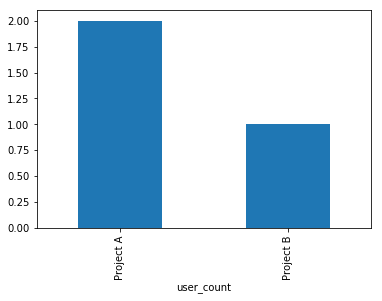

In [58]:
fig,ax=plt.subplots()
project_user_count.plot(kind='bar')
plt.show()